In [48]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image ,  ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [49]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [50]:
import os
import cv2
import numpy as np
import glob

def imagePrep(path_pattern, WIDTH, HEIGHT, CHANNEL): 
    
    filelist = glob.glob(path_pattern)
    fileabslist = [os.path.abspath(fpath) for fpath in filelist]
    X = []
    for fname in fileabslist:
        img = cv2.imread(fname).astype('float32') / 255
        #print(img.shape)
        img = cv2.resize(img, (WIDTH, HEIGHT))
        if CHANNEL == 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=2)
        else:         
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)
    X_array = np.array(X)
    
    
    return X_array

In [51]:
HEIGHT, WIDTH, CHANNEL = 512, 512, 3
X_train = imagePrep('data/train/*.jpg', WIDTH, HEIGHT, CHANNEL)
X_test = imagePrep('data/test/*.jpg', WIDTH, HEIGHT, CHANNEL)
Y_train = imagePrep('data/target/*.jpg', WIDTH, HEIGHT, CHANNEL)
print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)
print(Y_train.shape, Y_train.dtype)

(28, 512, 512, 3) float32
(11, 512, 512, 3) float32
(28, 512, 512, 3) float32


In [19]:
#train_input, test_input, train_target, test_target = train_test_split(X_train,Y_train)

#print( train_input.shape, train_target.shape)
#print( test_input.shape, test_target.shape)

(21, 512, 512, 3) (21, 512, 512, 3)
(7, 512, 512, 3) (7, 512, 512, 3)


In [5]:
import matplotlib.pyplot as plt
def imageVis(X):
    fig, ax = plt.subplots(1, 10, figsize=(20, 4))
    for i, img in enumerate(X[:10]):
        ax[i].imshow(img.reshape(WIDTH, HEIGHT,3))
    return fig

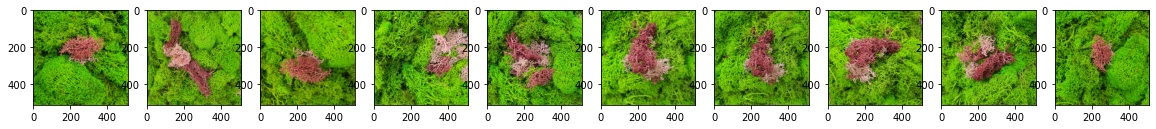

In [6]:
fig = imageVis(X_train)
plt.show()

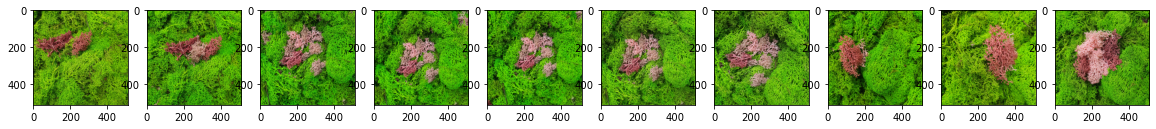

In [7]:
fig = imageVis(X_test)
plt.show()

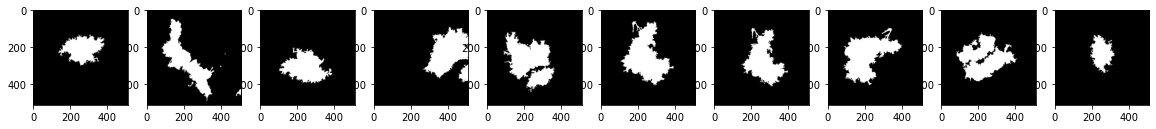

In [8]:
fig = imageVis(Y_train)
plt.show()

In [9]:
model = get_model((512, 512), 3)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

#모델 저장 폴더 설정
import os

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)


#모델 저장 조건 설정
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath = './model/{epoch:02d}-{accuracy:.4f}.hdf5'

#모델 업데이트 및 저장
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'accuracy', 
                              verbose = 1, save_best_only = True)


In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

In [54]:
model.fit(X_train, Y_train, epochs=50, batch_size=4, validation_data=(X_train, Y_train), callbacks = [checkpointer])

model.save('model/model_epochs50_bz4.h5')

Epoch 1/50
7/7 [==============================] - 25s 3s/step - loss: 69461206761472.0000 - accuracy: 0.5692 - val_loss: 22658550857728.0000 - val_accuracy: 0.1776

Epoch 00001: accuracy improved from -inf to 0.61613, saving model to ./model\01-0.6161.hdf5
Epoch 2/50
7/7 [==============================] - 23s 3s/step - loss: 29370951663616.0000 - accuracy: 0.1873 - val_loss: 33605654937600.0000 - val_accuracy: 0.8172

Epoch 00002: accuracy did not improve from 0.61613
Epoch 3/50
7/7 [==============================] - 24s 3s/step - loss: 33771095588864.0000 - accuracy: 0.6156 - val_loss: 21764824367104.0000 - val_accuracy: 0.1772

Epoch 00003: accuracy did not improve from 0.61613
Epoch 4/50
7/7 [==============================] - 26s 4s/step - loss: 32308569833472.0000 - accuracy: 0.3231 - val_loss: 29467483308032.0000 - val_accuracy: 0.0181

Epoch 00004: accuracy did not improve from 0.61613
Epoch 5/50
7/7 [==============================] - 27s 4s/step - loss: 33313273151488.0000 - acc


Epoch 00038: accuracy did not improve from 0.61613
Epoch 39/50
7/7 [==============================] - 28s 4s/step - loss: 381731356016640.0000 - accuracy: 0.2169 - val_loss: 351305306472448.0000 - val_accuracy: 0.0035

Epoch 00039: accuracy did not improve from 0.61613
Epoch 40/50
7/7 [==============================] - 28s 4s/step - loss: 295568207249408.0000 - accuracy: 0.2321 - val_loss: 357203370311680.0000 - val_accuracy: 0.0037

Epoch 00040: accuracy did not improve from 0.61613
Epoch 41/50
7/7 [==============================] - 28s 4s/step - loss: 482706022465536.0000 - accuracy: 0.3092 - val_loss: 653201913151488.0000 - val_accuracy: 0.1675

Epoch 00041: accuracy did not improve from 0.61613
Epoch 42/50
7/7 [==============================] - 28s 4s/step - loss: 484689110368256.0000 - accuracy: 0.2584 - val_loss: 312564667908096.0000 - val_accuracy: 0.1687

Epoch 00042: accuracy did not improve from 0.61613
Epoch 43/50
7/7 [==============================] - 28s 4s/step - loss: 3

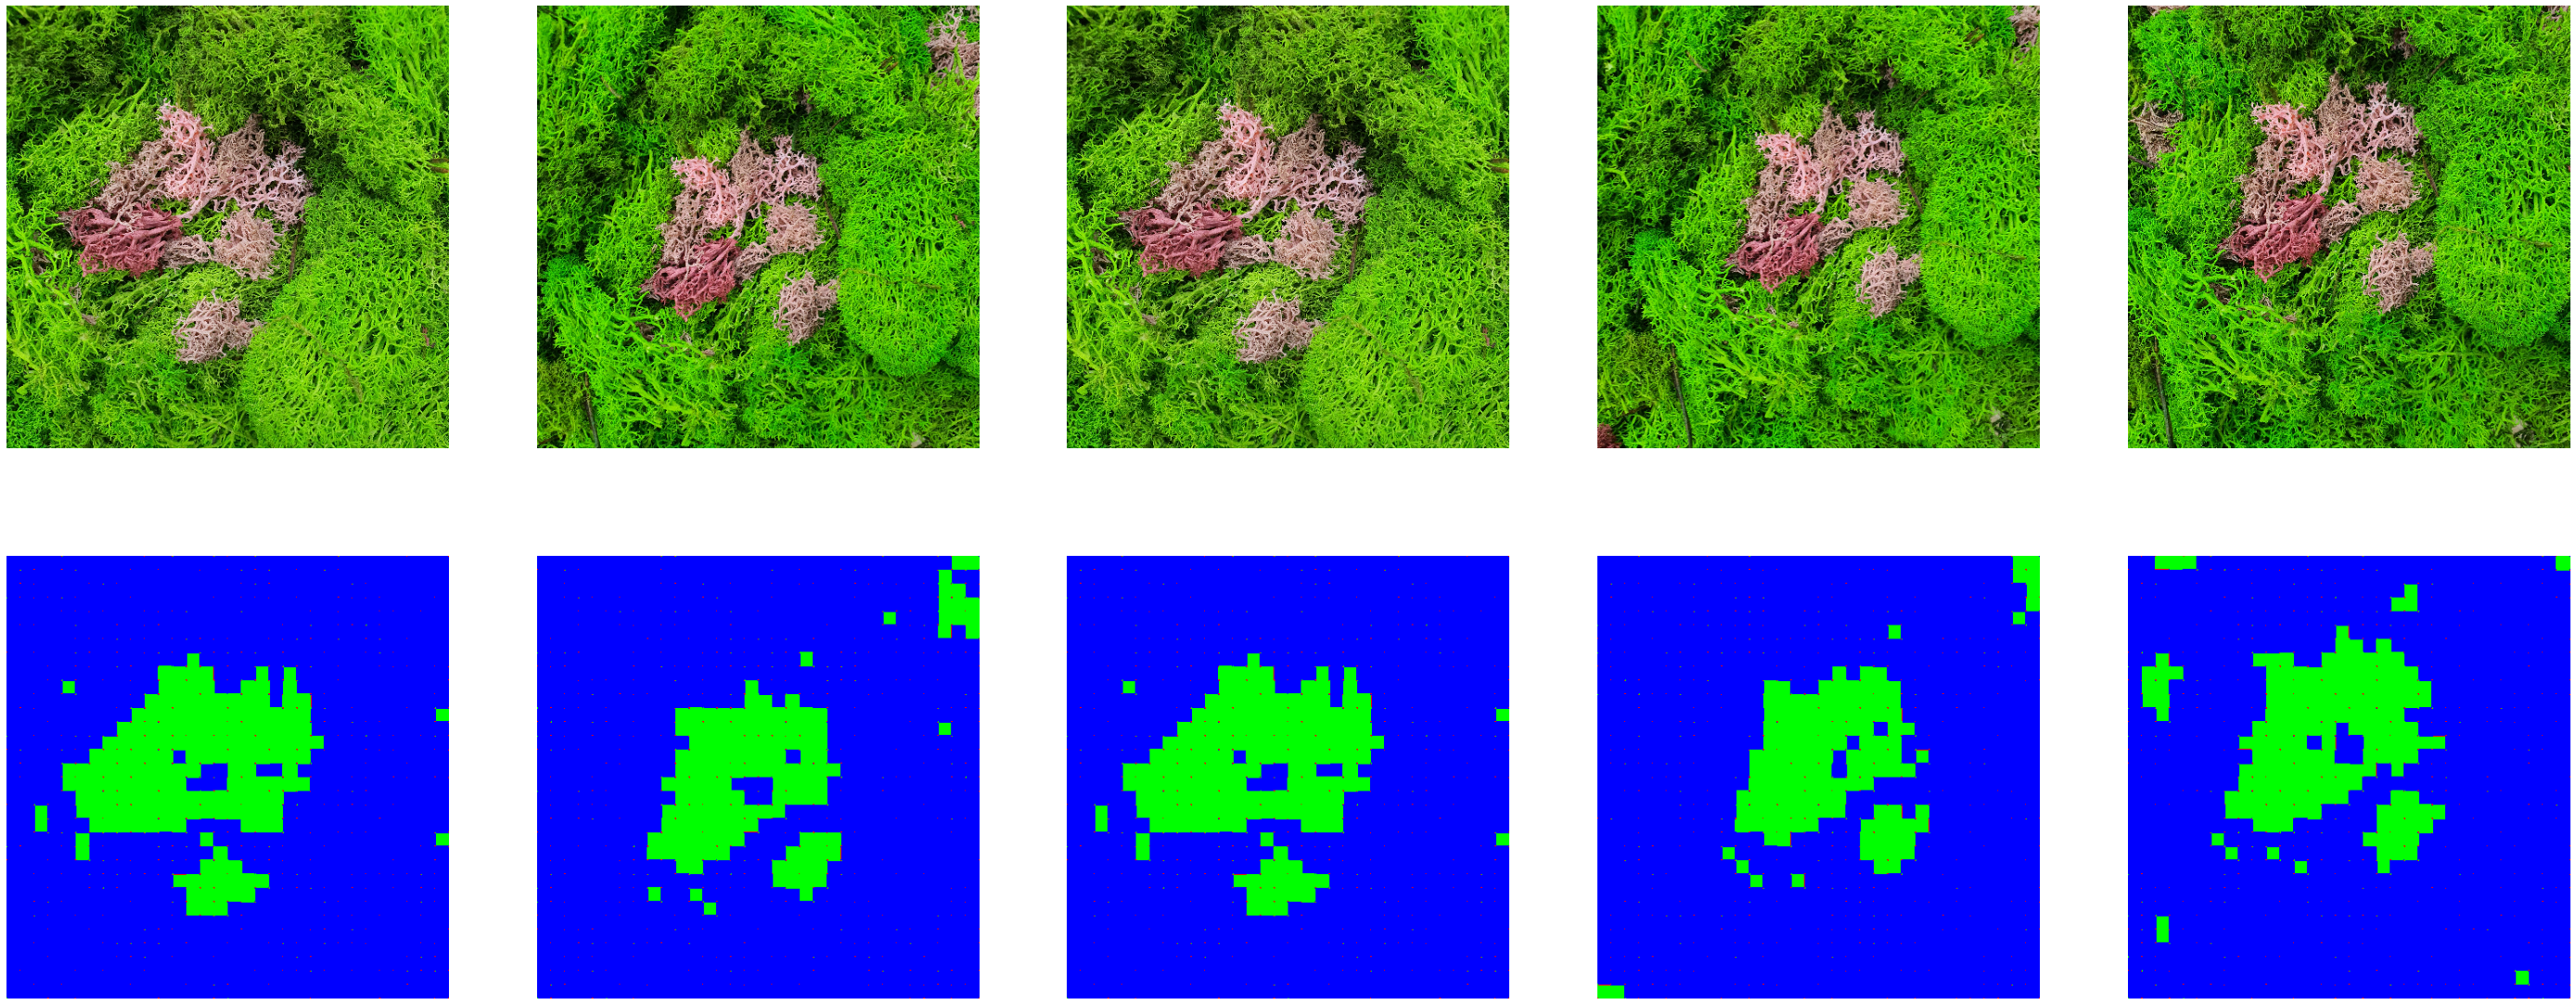

In [55]:

import cv2
#학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  #테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = model.predict(X_test)  #앞서 만든 오토인코더 모델에 집어 넣습니다.


plt.figure(figsize=(70, 20))  #출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):    #랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx])  #테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
    
    
   plt.imshow(ae_imgs[image_idx])  #오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()


In [43]:
# 모델 save

model = load_model('model/10-17686182494208.0000.hdf5')

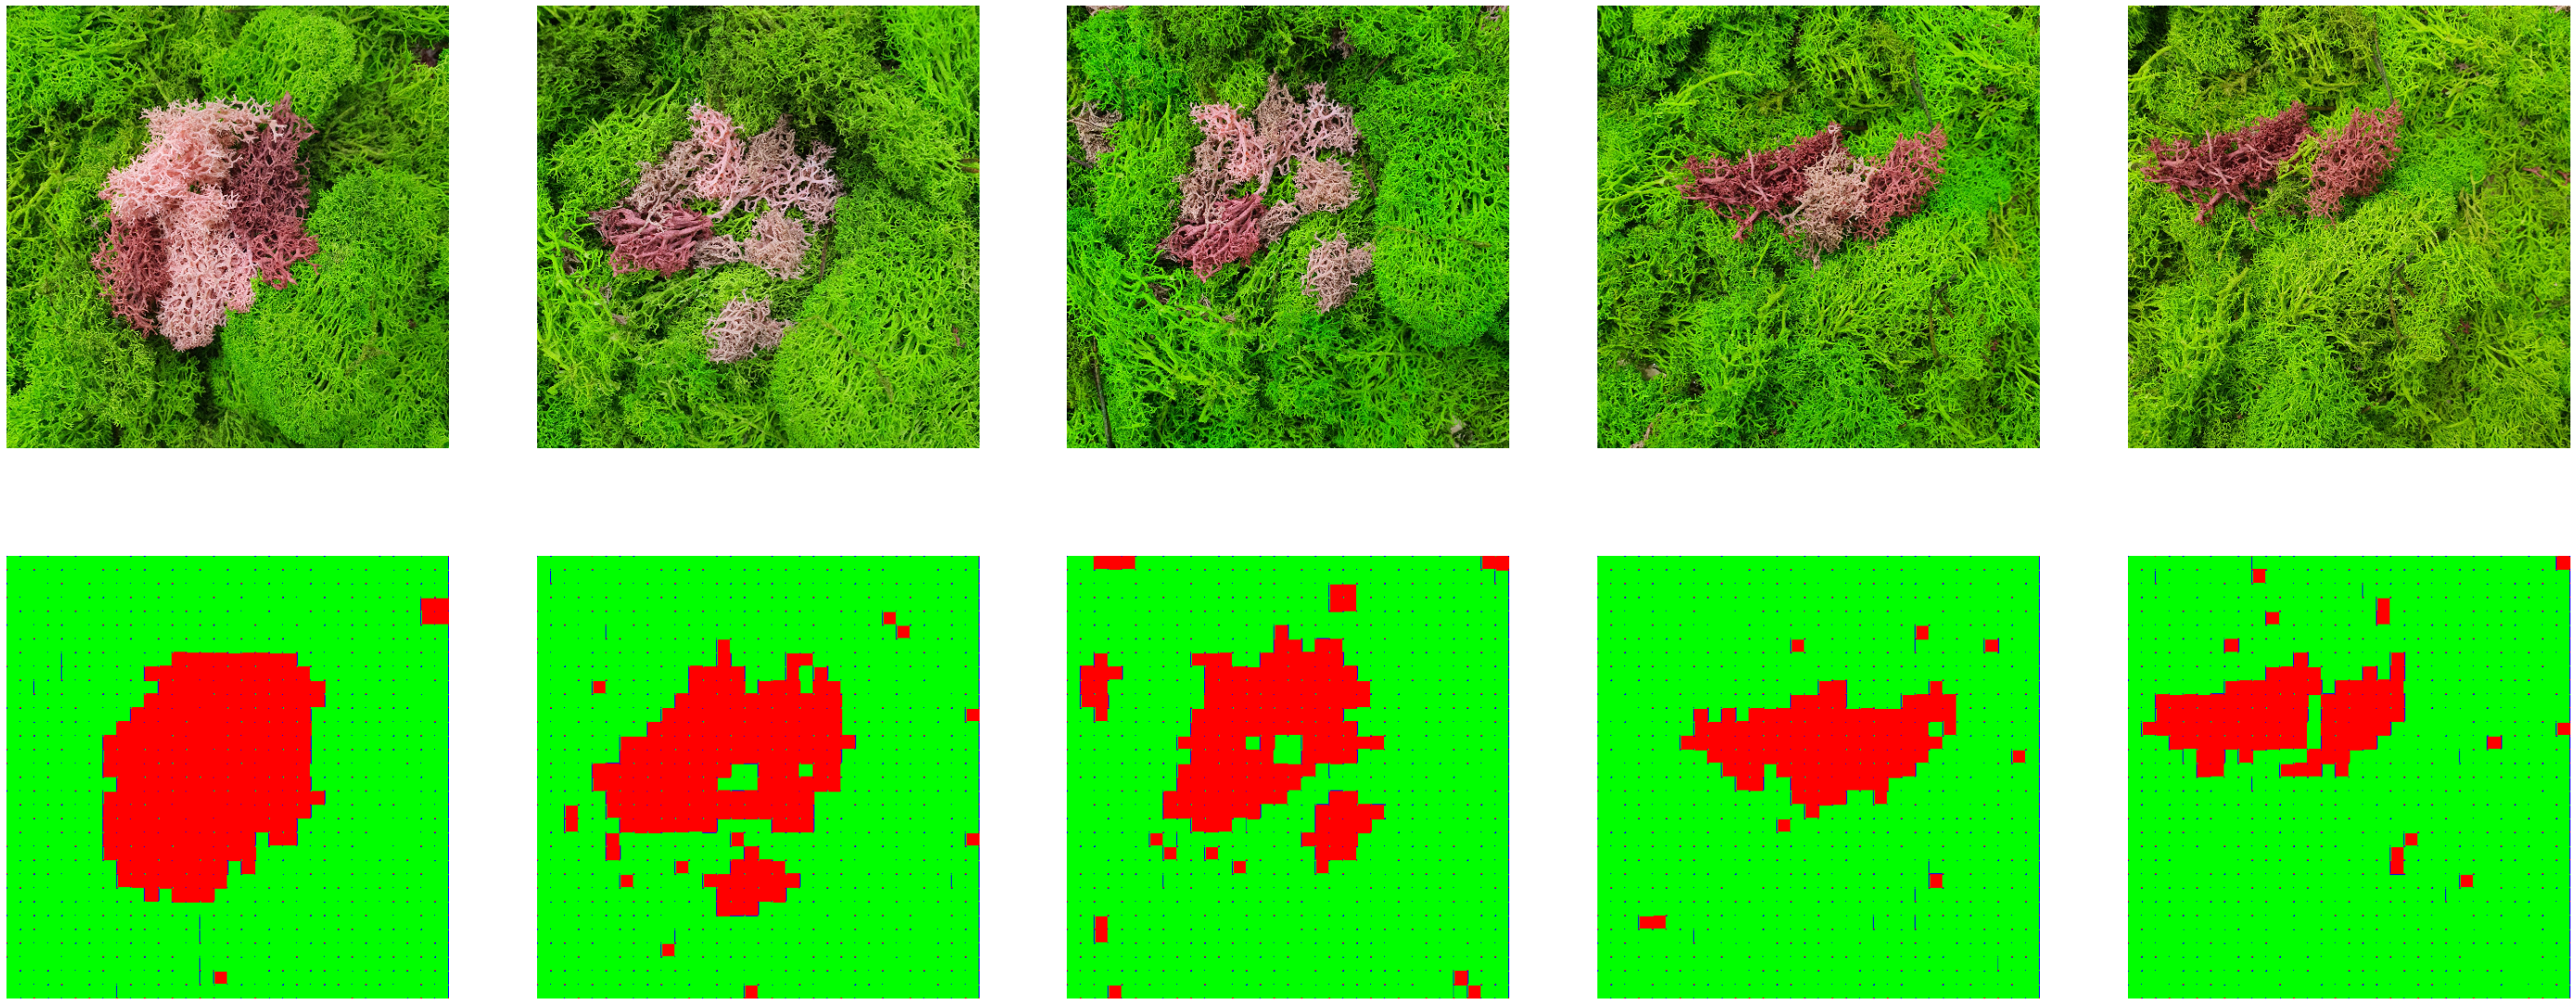

In [45]:
#학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  #테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = model.predict(X_test)  #앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(70, 20))  #출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):    #랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx])  #테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')



   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx])  #오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()

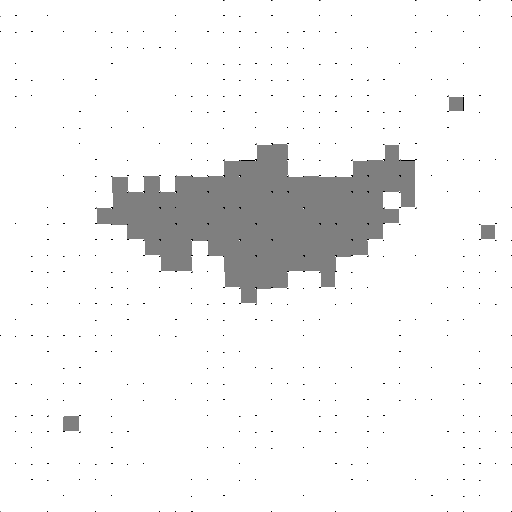

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'morphologyEx'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [56]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(ae_imgs[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
    dst = cv2.morphologyEx(img, cv2.MORPH_DILATE, None)
   
display_mask(1)